# Interpret embedding Results

## Imports, Settings, Data

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier.util_data import *

In [81]:
# options
%load_ext autoreload
%autoreload 2
%matplotlib inline
# plt.style.use("seaborn")
mpl.rcParams["figure.dpi"] = 200
# warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
root = "/home/jupyter/data/slide-seq/original_data/"
# root = "/data/"

df_wt1 = pd.read_csv(root + "wt_1.csv")
df_wt2 = pd.read_csv(root + "wt_2.csv")
df_wt3 = pd.read_csv(root + "wt_3.csv")
df_dis1 = pd.read_csv(root + "sick_1.csv")
df_dis2 = pd.read_csv(root + "sick_2.csv")
df_dis3 = pd.read_csv(root + "sick_3.csv")

In [4]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 100
input_size = 224
num_ftrs = 32
pixel_size = 5
crop_size = 224
input_channels = 9
n_element_min = 200

In [6]:
all_df = [df_wt1, df_wt2,df_wt3, df_dis1, df_dis2, df_dis3]
sparse_images = [
    SparseImage.from_panda(
        df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
    ) 
    for df in all_df
]

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 938, 939])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 940, 940])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 937, 940])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])
number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 928, 928])


In [7]:
# labels_sparse_images = ["wt1", "wt2", "wt3", "dis1", "dis2", "dis3"]
# labels_sparse_images = [0, 0, 1, 1 ]
labels_sparse_images = [0, 1, 2 , 3, 4, 5]

In [8]:
n_crops_test = 100

testdata_transform = torchvision.transforms.Compose([
    StackTensor(dim=-4),
    RandomGaussianBlur(sigma=(1.0, 5.0)),
    torchvision.transforms.Resize(input_size)
])

testdataset = SparseDataset(
    x=RandomCropSparseTensor(
        n_crops=n_crops_test,
        crop_size=crop_size,
        n_element_min=n_element_min,
        test_cache_key="test"
    )(sparse_images), 
    y=Interleave(n_repeat=n_crops_test)(labels_sparse_images)
)

dataloader_test = DataLoaderWithLoad(
    testdataset,
    batch_size=batch_size,
    collate_fn=SpecialCollateFn(transform=testdata_transform, simclr_output=False),
    shuffle=False
)

## Image Crops to Raw Crops

In [9]:
from tissue_purifier.simple_cache import cache
# cache["test"]

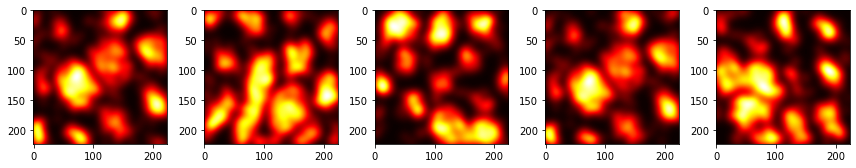

In [10]:
imgs, labels, fname = next(iter(dataloader_test))
# print(imgs.shape, labels.shape, fname.shape)
show_tensor(imgs[:5, 0], figsize=(12,4), n_col=5, cmap='hot', normalize_range=(0.0, 1.0))

In [11]:
imgs.shape

torch.Size([256, 9, 224, 224])

In [12]:
# sample_indicies = [0, 1, 2, 3] * n_crops_test
sample_indicies = labels_sparse_images * n_crops_test
sample_indicies.sort()

In [13]:
first = sparse_images[sample_indicies[0]].data.to_dense().cpu().numpy()

In [14]:
# raw_coords = sparse_images[0].pixel_to_raw(cache["test"][:5][:,0], cache["test"][:5][:, 1])

In [54]:
def plot_spatial_crop(df, pixel_size, x, y):
    x_t = x.item() * pixel_size + df.x.min() - 10 * 5
    y_t = y.item() * pixel_size + df.y.min() - 10 * 5
    plt.figure(figsize=(7, 7))
    a = df[
        (df.x > x_t) 
        & (df.y > y_t) 
        & (df.x < x_t + (crop_size * pixel_size)) 
        & (df.y < y_t + (crop_size * pixel_size))
    ]
    a = a[a.cell_type == 1]
    plt.scatter(a.x, a.y, c=a.cell_type, s=50)
    plt.show()
    
def plot_raster_crop(x, y, sample):
    plt.figure(figsize=(7, 7))
    crop = np.rot90(sample[0, x_:x_ + crop_size, y_: y_ + crop_size])
    plt.imshow(crop, cmap="hot")

In [55]:
x_, y_ = cache["test"][0]

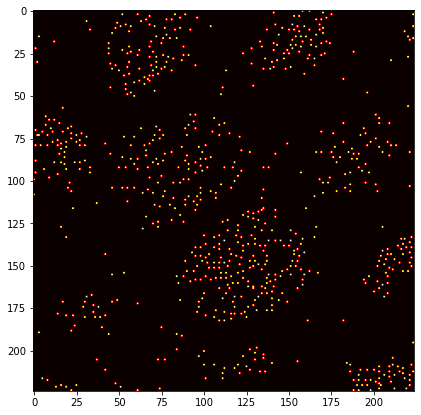

In [56]:
plot_raster_crop(x_, y_, first)

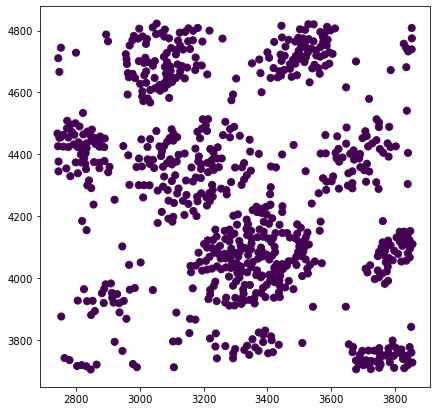

In [57]:
plot_spatial_crop(df_wt1, 5, x_, y_)

### SimCLR model, Embeddings

In [22]:
from torch import nn
import torchvision

resnet = torchvision.models.resnet18()
last_conv_channels = list(resnet.children())[-1].in_features
first_conv_out_channels = list(resnet.children())[0].out_channels
backbone = torch.nn.Sequential(
    torch.nn.Conv2d(input_channels, first_conv_out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    *list(resnet.children())[1:-1],
    torch.nn.Conv2d(last_conv_channels, num_ftrs, 1),
)

ckpt = torch.load('model.pth')
backbone.load_state_dict(ckpt['resnet18_parameters'])
# create the SimCLR model using the loaded created backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

In [176]:
model

SimCLR(
  (backbone): Sequential(
    (0): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [25]:
import torch
import lightly

criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_test
)

In [177]:
embeddings.shape

(600, 32)

In [27]:
# device = 'cuda' if gpus==1 else 'cpu'
device = "cuda"
encoder = encoder.to(device)

embeddings, labels, fnames = encoder.embed(dataloader_test, device=device, to_numpy=True)

Compute efficiency: 0.09: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier.util_data import *

In [30]:
def plot_knn_examples(embeddings, dataloader: DataLoaderWithLoad, n_neighbors=3, num_examples=6, figsize=(6,6)):
    """
    Select some random examples and show the their nearest neighbors
    """
    
    # For each sample get n_neighbours indices and distances 
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    nbrs_distances, nbrs_indices = nbrs.kneighbors(embeddings)  # shape: len_dataset, n_neighbours
   
    # get some random samples
    samples_idx = numpy.random.choice(nbrs_indices.shape[0], size=num_examples, replace=False)
    
    # plot the randomly picked examples and their neighbours
    fig, ax = plt.subplots(ncols=n_neighbors, nrows=num_examples, figsize=figsize) 
    for r, idx in enumerate(samples_idx):
        indeces = list(nbrs_indices[idx])
        distances = list(nbrs_distances[idx])
        tensors, labels, fnames = dataloader.load(index=indeces)
        # print(tensors.shape) # n_neighbours, ch, w, h
        for c in range(n_neighbors):
            #img = tensors[c,0].cpu().numpy() # plot just the first 3 channels
            img = tensors[c,:3].permute(1,2,0).cpu().numpy() # plot just the first 3 channels
            img = (img - numpy.min(img))/(numpy.max(img)-numpy.min(img))
            ax[r,c].imshow(img)  
            ax[r,c].set_title(f'd={distances[c]:.3f}')
            ax[r,c].set_axis_off()
    plt.close(fig)
    return fig 

In [31]:
img = plot_knn_examples(embeddings, dataloader_test, n_neighbors=10, num_examples=30, figsize=(20,80))

In [32]:
img.savefig("./knn_embeddings.png")

## UMAP

In [170]:
import umap
from sklearn.preprocessing import StandardScaler


reducer = umap.UMAP(n_neighbors=20, min_dist=0.1)
scaled_embeddings = StandardScaler().fit_transform(embeddings)
umap_embedded = reducer.fit_transform(scaled_embeddings)

In [144]:
plt.style.use("seaborn")

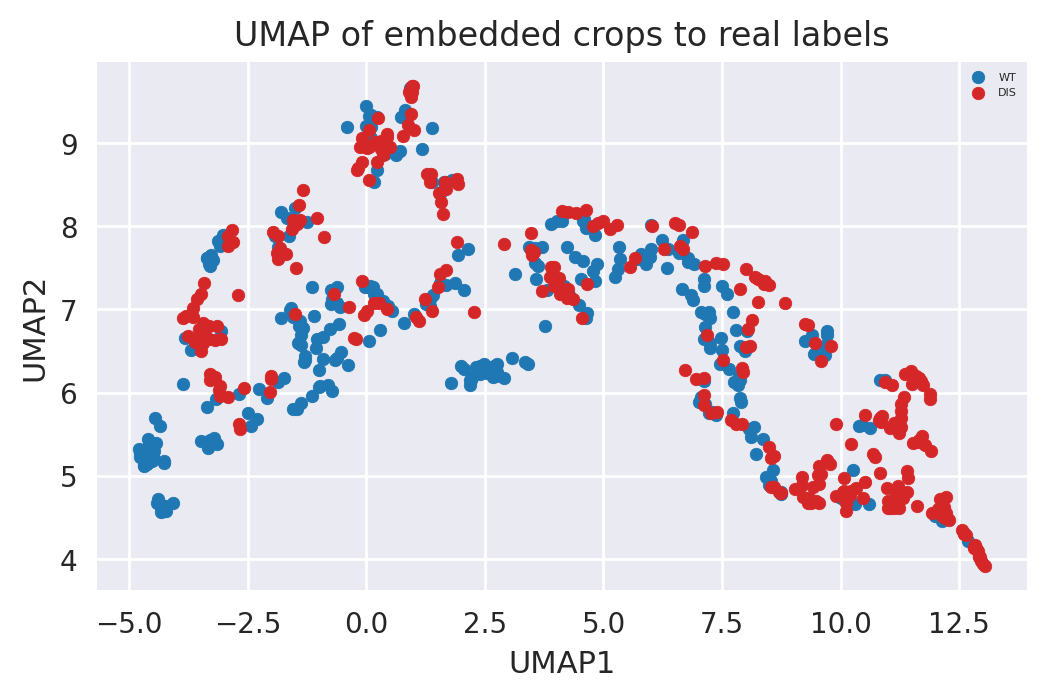

In [175]:
sample_indicies = np.array(sample_indicies)
fig = plt.figure(figsize=(6, 3.5))
# plt.scatter(umap_embedded[:, 0], umap_embedded[:, 1], c=sample_indicies, cmap="tab10");
conditions = [0, 0, 0, 1, 1, 1]
scatters = []
for sample in pd.Series(sample_indicies).unique():
    sample_umap = umap_embedded[sample_indicies==sample, :]
    condition = conditions[sample]
    color = "tab:red" if condition == 1 else "tab:blue"
    scatt = plt.scatter(sample_umap[:, 0], sample_umap[:, 1], label="WT" if condition == 0 else "DIS", s=20, c=color)
    scatters.append(scatt)
    
plt.legend([scatters[0], scatters[3]], ["WT", "DIS"], fontsize=4)
plt.title("UMAP of embedded crops to real labels")
# plt.xticks([])
# plt.yticks([])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()
fig.savefig("UMAP or label")

## Moran Score

In [96]:
from anndata import AnnData
import squidpy as sq
from sklearn.preprocessing import OneHotEncoder

def calculate_morans_score(df):
    features = OneHotEncoder().fit_transform(df[["cell_type"]]).toarray()
    coords = df[["x", "y"]].to_numpy()
    obs = pd.DataFrame(df["cell_type"])
    adata = AnnData(X=features, obsm={"spatial": coords}, obs=obs)
    sq.gr.spatial_neighbors(adata)
    sq.gr.moran(adata, show_progress_bar=False)
    return adata.uns["moranI"].sort_index()

In [97]:
from tissue_purifier.simple_cache import cache


def get_morans(dataloader):
    """
        Calculate Morans scores for dataloader. 
        Works only when labels corresponds to indicies of df from `all_df`
    """
    crop_coords = cache["test"]
    moran_scores_batches = []
    i = 0
    for imgs_batch, labels_batch, _ in dataloader:
        moran_scores = []
        for img, label in zip(imgs_batch, labels_batch):
            x_, y_ = crop_coords[i]
            df = all_df[label]
            x_raw = x_.item() * pixel_size + df.x.min() - 10*5 #10*5 – padding
            y_raw = y_.item() * pixel_size + df.y.min() - 10*5
            df_query = df[
                (df.x > x_raw) & (df.y > y_raw) 
                & (df.x < x_raw + (crop_size * pixel_size)) 
                & (df.y < y_raw + (crop_size * pixel_size))
            ]
            df_query = df_query[df_query.cell_type.isin([1, 2, 4])]
            moran_score = calculate_morans_score(df_query)["I"]
            moran_score = moran_score.mean()
            moran_scores.append(moran_score)
            i += 1
            
        moran_scores_batches.append(moran_scores)
        
    return moran_scores_batches

In [98]:
%%capture
morans = get_morans(dataloader_test)

In [119]:
# morans = list(morans)
morans = [np.array(mr) for mr in morans]
morans = np.concatenate(morans)

In [172]:
morans[umap_embedded[:, 0] > 5].mean()

0.4404614695121743

In [173]:
morans[umap_embedded[:, 0] < 5].mean()

0.4986203321857496

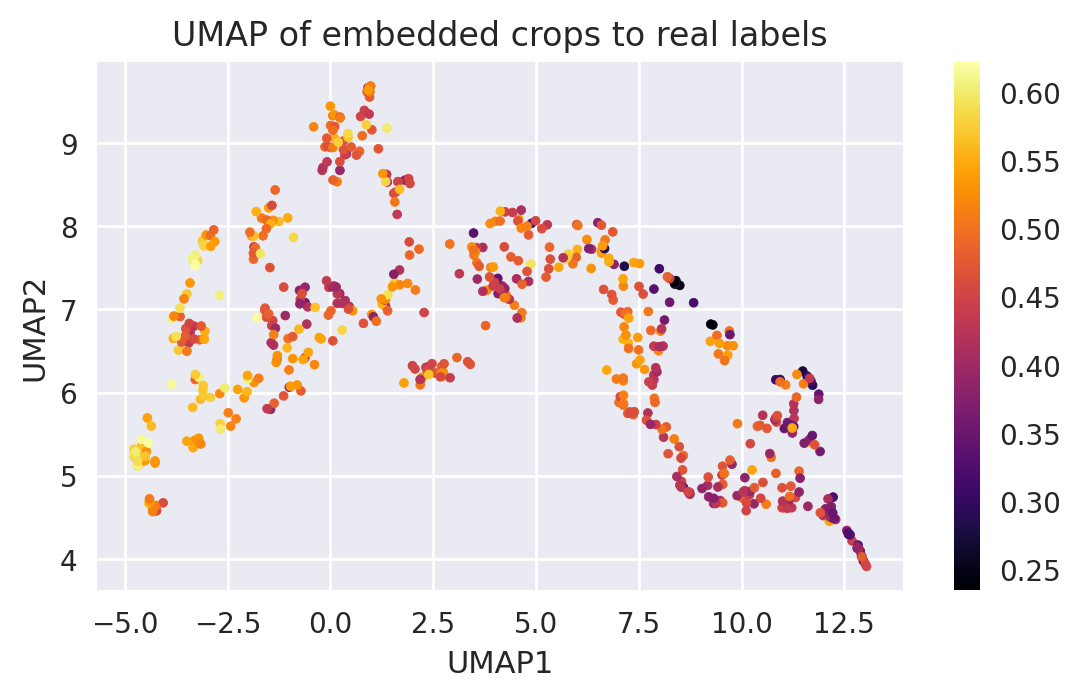

In [171]:
# sample_indicies = np.array(sample_indicies)
fig = plt.figure(figsize=(6.5, 3.5))
plt.scatter(umap_embedded[:, 0], umap_embedded[:, 1], c=morans, cmap="inferno", s=10);
plt.title("UMAP of embedded crops to real labels")
plt.colorbar()
# plt.xticks([])
# plt.yticks([])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()
fig.savefig("UMAP morans")